<a href="https://colab.research.google.com/github/AdamAnderB/CMUsic_HDDM/blob/main/Working_HDDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install virtualenv
!virtualenv venv
!source venv/bin/activate

!pip install pymc #==5.6.0
!pip install ssm-simulators #==0.3.1
!pip install huggingface-hub #>=0.16.4
!pip install blackjax
!pip install graphviz

!pip install numpy==1.25.4 #was 1.24.4
!pip install git+https://github.com/lnccbrown/hssm@main
!pip install git+https://github.com/brown-ccv/hddm-wfpt@main
!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 34.1 MB/s eta 0:00:00
created virtual environment CPython3.10.12.final.0-64 in 861ms
  creator CPython3Posix(dest=/content/venv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==23.3.1, setuptools==69.0.2, wheel==0.42.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.1/300.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 7.7 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement numpy==1.25.4 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.

In [4]:
from ssms.basic_simulators import simulator
import numpy as np
import pandas as pd

# Basics
import os
import sys
import time
import jax

from matplotlib import pyplot as plt
import arviz as az  # Visualization
import pytensor  # Graph-based tensor library
import hssm

# import ssms.basic_simulators # Model simulators
import hddm_wfpt
import bambi as bmb

# Setting float precision in pytensor
pytensor.config.floatX = "float32"

from jax.config import config

jax.config.update("jax_enable_x64", False)

!pip install --upgrade --force-reinstall scipy

<ipython-input-4-469d3a9ef623>:23: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 22.5 MB/s eta 0:00:00
  Using cached numpy-1.26.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.2 which is incompatible.
hssm 0.1.5 requires num

In [5]:
# Specify parameters
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.2]


# Simulate data
sim_out = simulator.simulator(
    theta=[v_true, a_true, z_true, t_true],  # parameter list
    model="ddm",  # specify model (many are included in ssms)
    n_samples=500,  # number of samples for each set of parameters
)

# Turn into nice dataset
# Turn data into a pandas dataframe
dataset = pd.DataFrame(
    np.column_stack([sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
    columns=["rt", "response"],
)

dataset

,rt,response
0,2.013111,-1.0
1,0.706921,-1.0
2,1.286359,1.0
3,1.025640,1.0
4,4.211424,-1.0
...,...,...
495,0.920755,1.0
496,3.107707,-1.0
497,1.438909,1.0
498,1.657910,1.0


In [6]:
from google.colab import files

uploaded = files.upload()


Saving sp_24_HDDM_music_data.csv to sp_24_HDDM_music_data.csv


In [7]:
file_name = list(uploaded.keys())[0]
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_name)
df.head()

,Unnamed: 0,Participant.Private.ID,Trial.Number,Spreadsheet.Name,Reaction.Time,rt_correct,Answer_correct,melody_score,beat_score,centered_beats,centered_melody
0,1,9353724,1,Mandarin,318.0,318.0,1,1.0,0.966667,0.649675,0.655506
1,2,9353724,2,Mandarin,369.0,369.0,1,1.0,0.966667,0.649675,0.655506
2,3,9353724,3,Mandarin,339.0,339.0,1,1.0,0.966667,0.649675,0.655506
3,4,9353724,4,Mandarin,609.0,609.0,1,1.0,0.966667,0.649675,0.655506
4,5,9353724,5,Mandarin,450.0,450.0,1,1.0,0.966667,0.649675,0.655506


In [26]:
#adduseful columns
df['rt'] = df['Reaction.Time']
df['response'] = df['Answer_correct']
df['response'] = df['response'].replace({0: -1})

#create Mandarin df
df_mandarin = df[df['Spreadsheet.Name'] == 'Mandarin']
df_mandarin = df_mandarin[['rt', 'response']]
#df_mandarin.head()

#create Italian df
df_italian = df[df['Spreadsheet.Name'] == 'italian']
df_italian = df_italian[['rt', 'response']]
#df_italian.head()

#create Japanese df
df_japanese = df[df['Spreadsheet.Name'] == 'japanese']
df_japanese = df_japanese[['rt', 'response']]
#df_japanese.head()

# Display the updated DataFrame
print(df_mandarin.head())
print(df_italian.head())
print(df_japanese.head())

#old stuff
#df = df[['rt', 'response']]

#summary = df1.describe()
#print(summary)
#df1.head()
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

# Display the DataFrame
#df1


      rt  response
0  318.0         1
1  369.0         1
2  339.0         1
3  609.0         1
4  450.0         1
         rt  response
3433  506.0         1
3434  865.0         1
3435  213.0         1
3436  215.0         1
3437  291.0         1
         rt  response
5196  835.0         1
5197  369.0         1
5198  297.0         1
5199  265.0         1
5200  341.0         1


In [27]:
simple_ddm_model_mandarin = hssm.HSSM(data=df_mandarin)
simple_ddm_model_italian = hssm.HSSM(data=df_italian)
simple_ddm_model_japanese = hssm.HSSM(data=df_japanese)

In [31]:
print(simple_ddm_model_mandarin)
print(simple_ddm_model_italian)
print(simple_ddm_model_japanese)

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 3433

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: (-inf, inf)
a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)
z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Prior: HalfNormal(sigma: 2.0, initval: 0.10000000149011612)
    Explicit bounds: (0.0, inf)

Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)
Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1763

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: (-inf, inf)
a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)
z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Prior: HalfNormal(sigma: 2.0, initval: 0.10000000149011612)
    Explicit bounds: (0.0, inf)

Lap

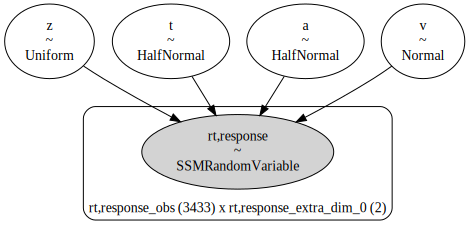

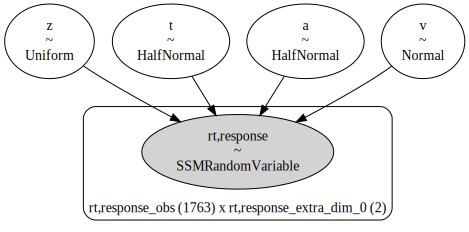

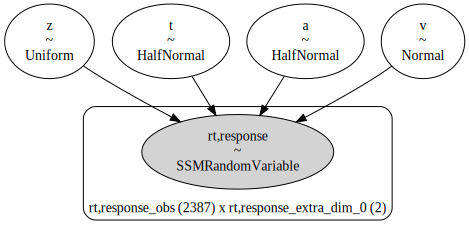

In [11]:
from IPython.display import display
display(simple_ddm_model_mandarin.graph())
display(simple_ddm_model_italian.graph())
display(simple_ddm_model_japanese.graph())

In [14]:
pip install --upgrade --force-reinstall scipy

  Using cached scipy-1.11.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.4 MB)
  Using cached numpy-1.26.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.2
    Uninstalling numpy-1.26.2:
      Successfully uninstalled numpy-1.26.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.2 which is incompatible.
hssm 0.

In [15]:
#Mandarin_model
infer_data_simple_ddm_model_mandarin = simple_ddm_model_mandarin.sample(
    sampler="nuts_numpyro",  # type of sampler to choose, 'nuts_numpyro', 'nuts_blackjax' of default pymc nuts sampler
    cores=1,  # how many cores to use
    chains=2,  # how many chains to run
    draws=500,  # number of draws from the markov chain
    tune=500,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),  # return log likelihood
)  # mp_ctx="forkserver")

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [16]:
type(infer_data_simple_ddm_model_mandarin)
infer_data_simple_ddm_model_mandarin
az.summary(infer_data_simple_ddm_model_mandarin)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.051,0.001,0.049,0.053,0.000,0.000,920.0,789.0,1.0
z,0.503,0.006,0.492,0.515,0.000,0.000,508.0,643.0,1.0
a,22.709,0.201,22.312,23.070,0.009,0.007,478.0,515.0,1.0
t,0.054,0.053,0.000,0.151,0.002,0.001,451.0,458.0,1.0


In [17]:
#Italian_model
infer_data_simple_ddm_model_italian = simple_ddm_model_italian.sample(
    sampler="nuts_numpyro",  # type of sampler to choose, 'nuts_numpyro', 'nuts_blackjax' of default pymc nuts sampler
    cores=1,  # how many cores to use
    chains=2,  # how many chains to run
    draws=500,  # number of draws from the markov chain
    tune=500,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),  # return log likelihood
)  # mp_ctx="forkserver")

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [18]:
type(infer_data_simple_ddm_model_italian)
infer_data_simple_ddm_model_italian
az.summary(infer_data_simple_ddm_model_italian)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,-0.324,0.370,-0.694,0.047,0.259,0.219,3.0,2.0,2.23
z,0.596,0.021,0.565,0.616,0.014,0.012,3.0,127.0,2.26
a,11.447,8.685,2.769,20.419,6.091,5.143,3.0,2.0,2.23
t,0.159,0.102,0.010,0.255,0.068,0.059,3.0,115.0,2.26


In [20]:
#Japanese_model
infer_data_simple_ddm_model_japanese = simple_ddm_model_japanese.sample(
    sampler="nuts_numpyro",  # type of sampler to choose, 'nuts_numpyro', 'nuts_blackjax' of default pymc nuts sampler
    cores=1,  # how many cores to use
    chains=2,  # how many chains to run
    draws=500,  # number of draws from the markov chain
    tune=500,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),  # return log likelihood
)  # mp_ctx="forkserver")

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [21]:
type(infer_data_simple_ddm_model_japanese)
infer_data_simple_ddm_model_japanese
az.summary(infer_data_simple_ddm_model_japanese)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.058,0.001,0.056,0.061,0.000,0.000,1017.0,850.0,1.0
z,0.468,0.008,0.454,0.483,0.000,0.000,676.0,491.0,1.0
a,22.762,0.245,22.267,23.180,0.010,0.007,659.0,486.0,1.0
t,0.066,0.065,0.000,0.194,0.002,0.002,494.0,422.0,1.0


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['log_likelihood'] have not been found and will be ignored
  warnings.warn(


rt          False
response    False
dtype: bool
rt          False
response    False
dtype: bool


'analytical'

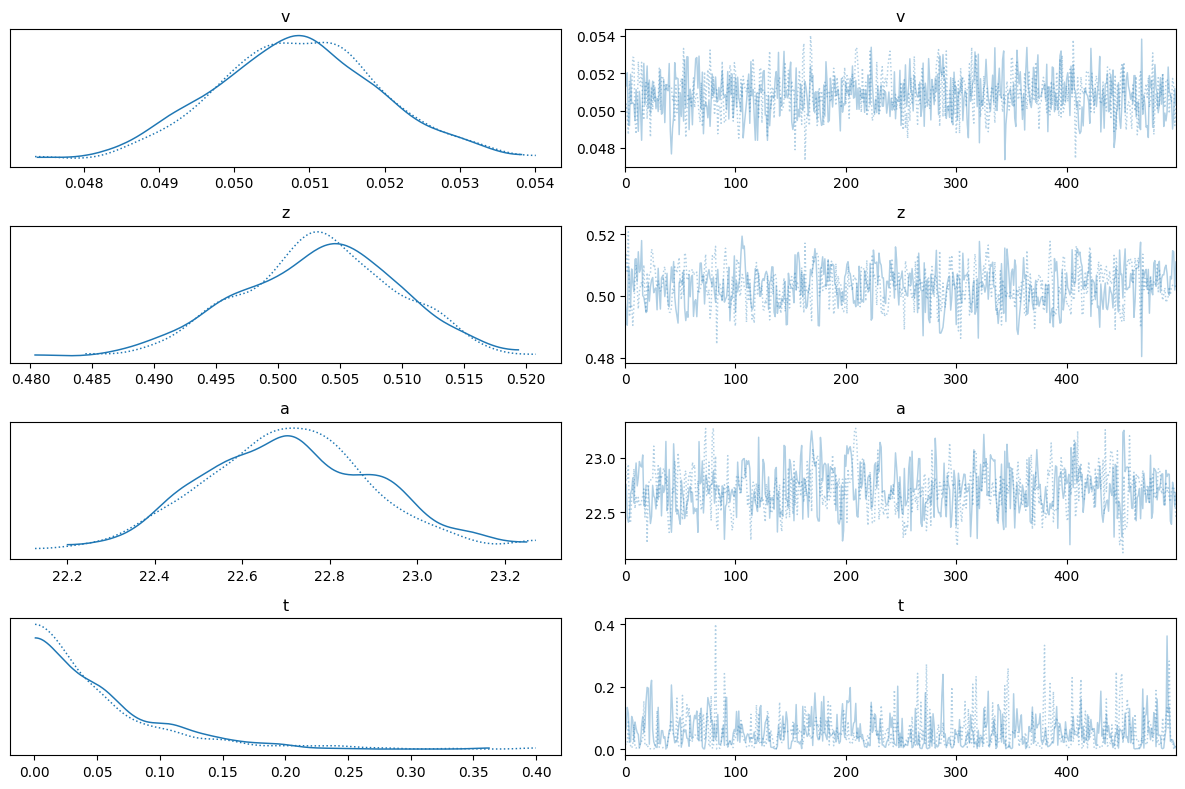

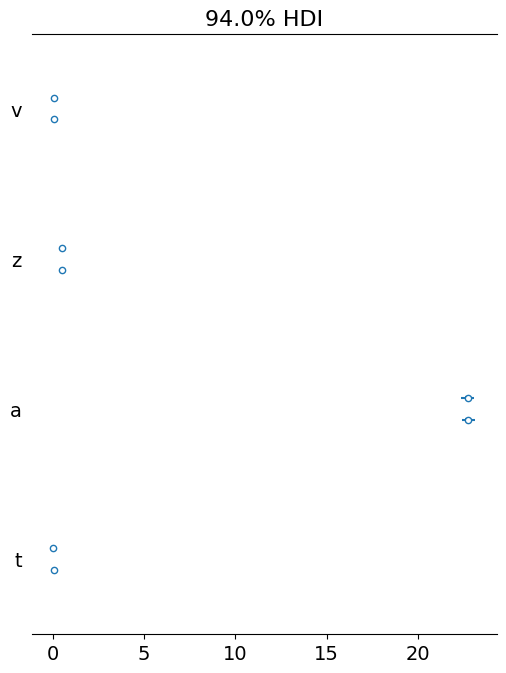

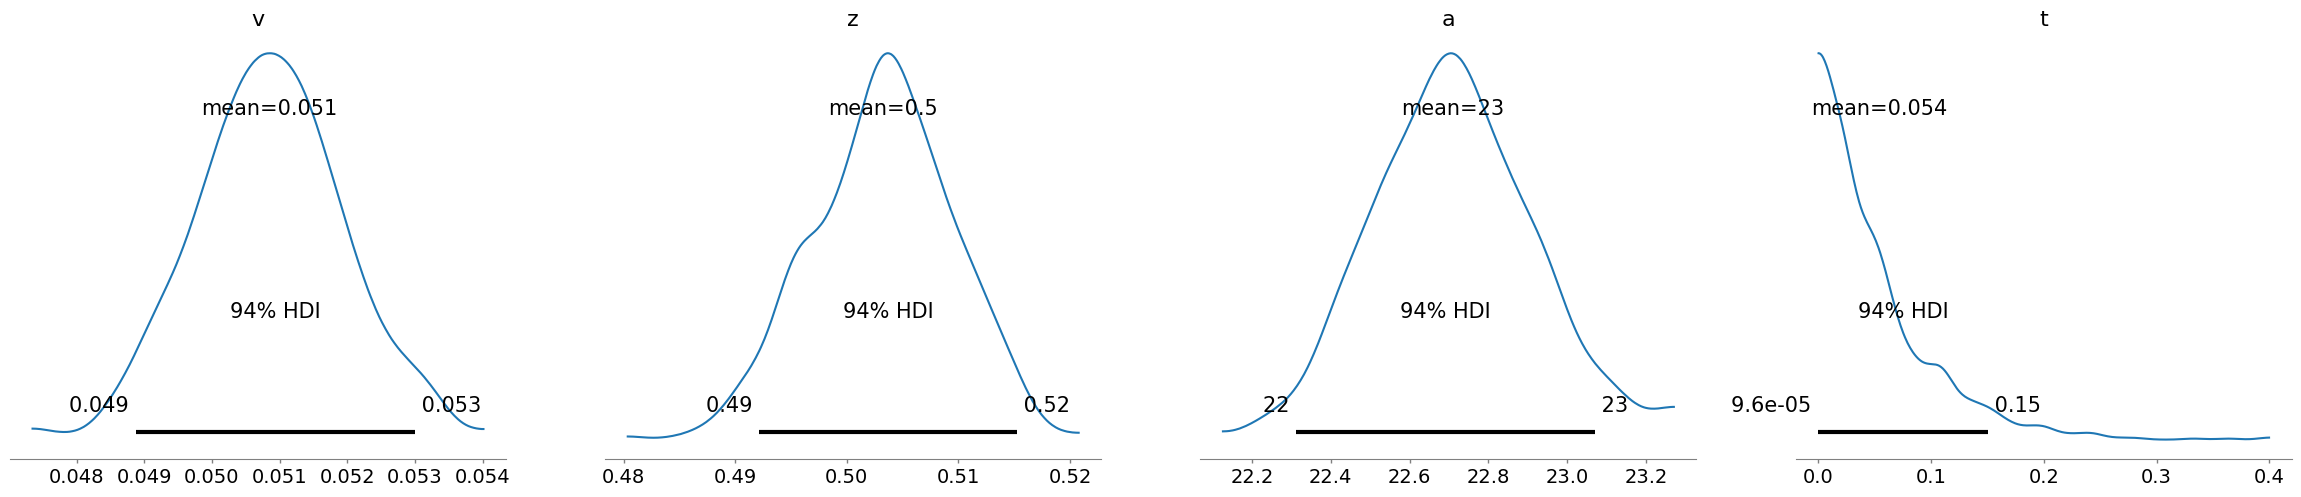

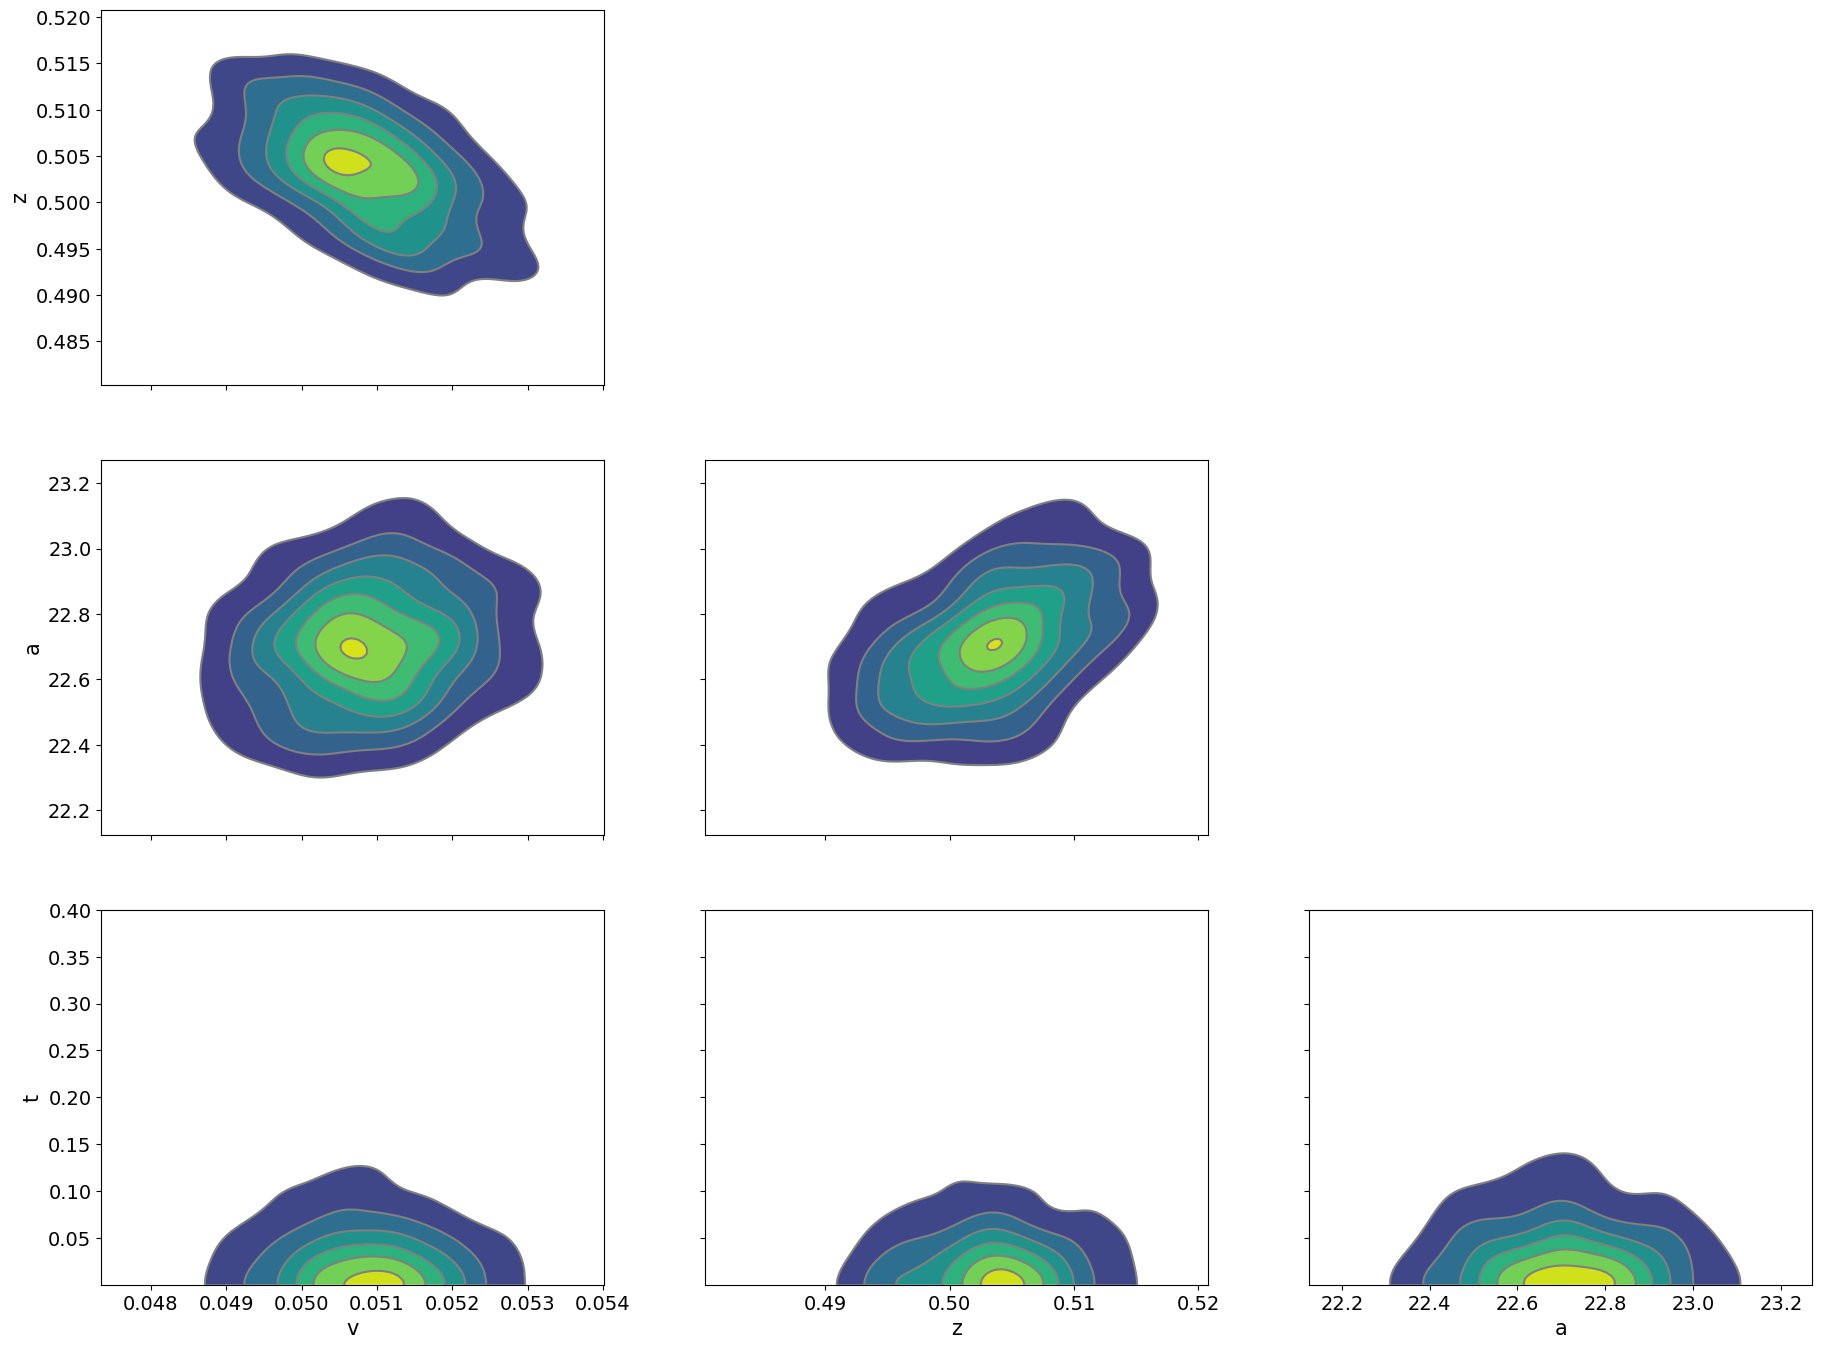

In [23]:
#Mandarin viz
az.plot_trace(
    infer_data_simple_ddm_model_mandarin,
    var_names="~log_likelihood",  # we exclude the log_likelihood traces here
)
plt.tight_layout()

#trouble shooting code
constant_values = np.all(df_mandarin == df_mandarin.iloc[0], axis=0)
print(constant_values)
# Check for NaN values
nan_values = df_mandarin.isnull().any()
print(nan_values)

az.plot_forest(simple_ddm_model_mandarin.traces)
az.plot_posterior(simple_ddm_model_mandarin.traces)
az.plot_pair(simple_ddm_model_mandarin.traces, kind="kde")
simple_ddm_model_mandarin.loglik_kind

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['log_likelihood'] have not been found and will be ignored
  warnings.warn(


rt          False
response    False
dtype: bool
rt          False
response    False
dtype: bool


'analytical'

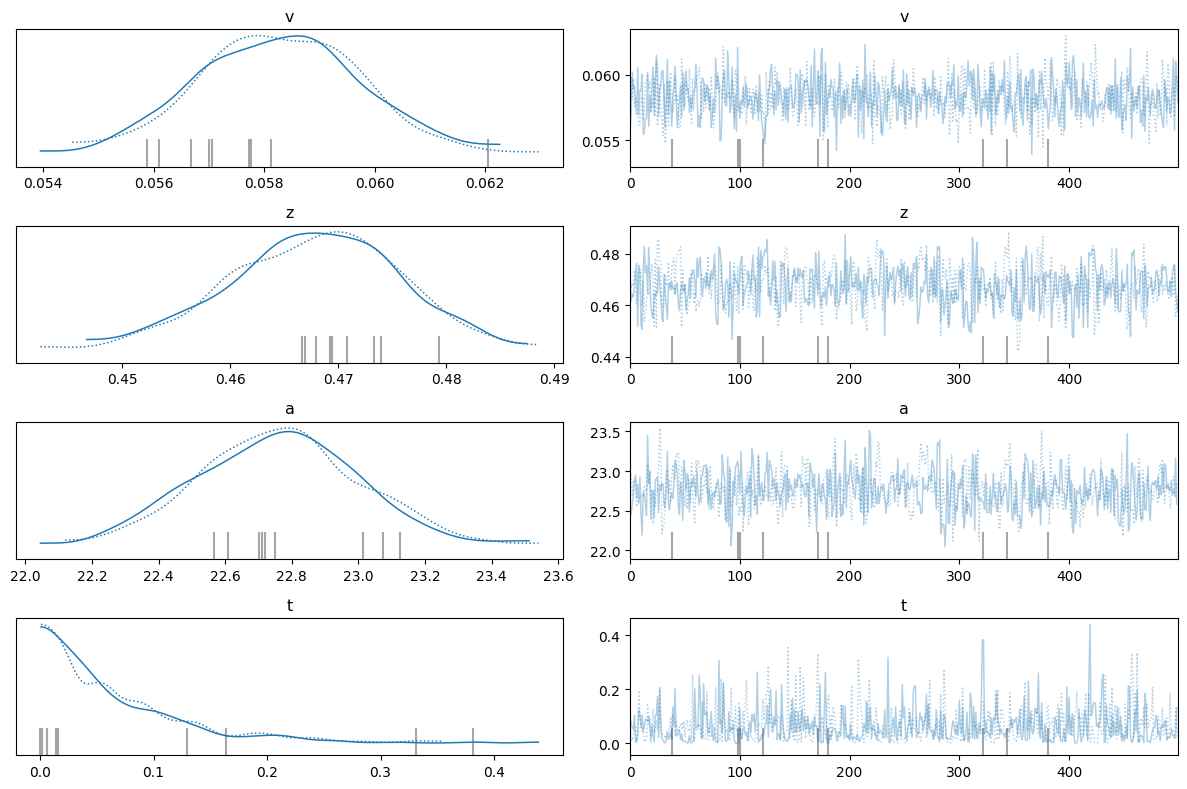

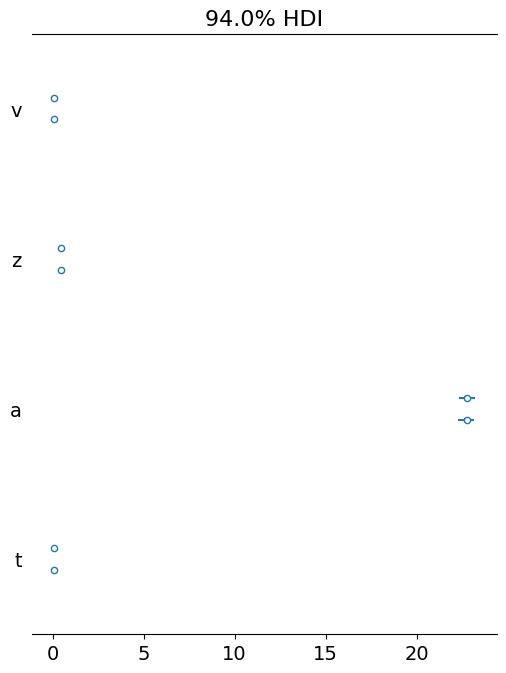

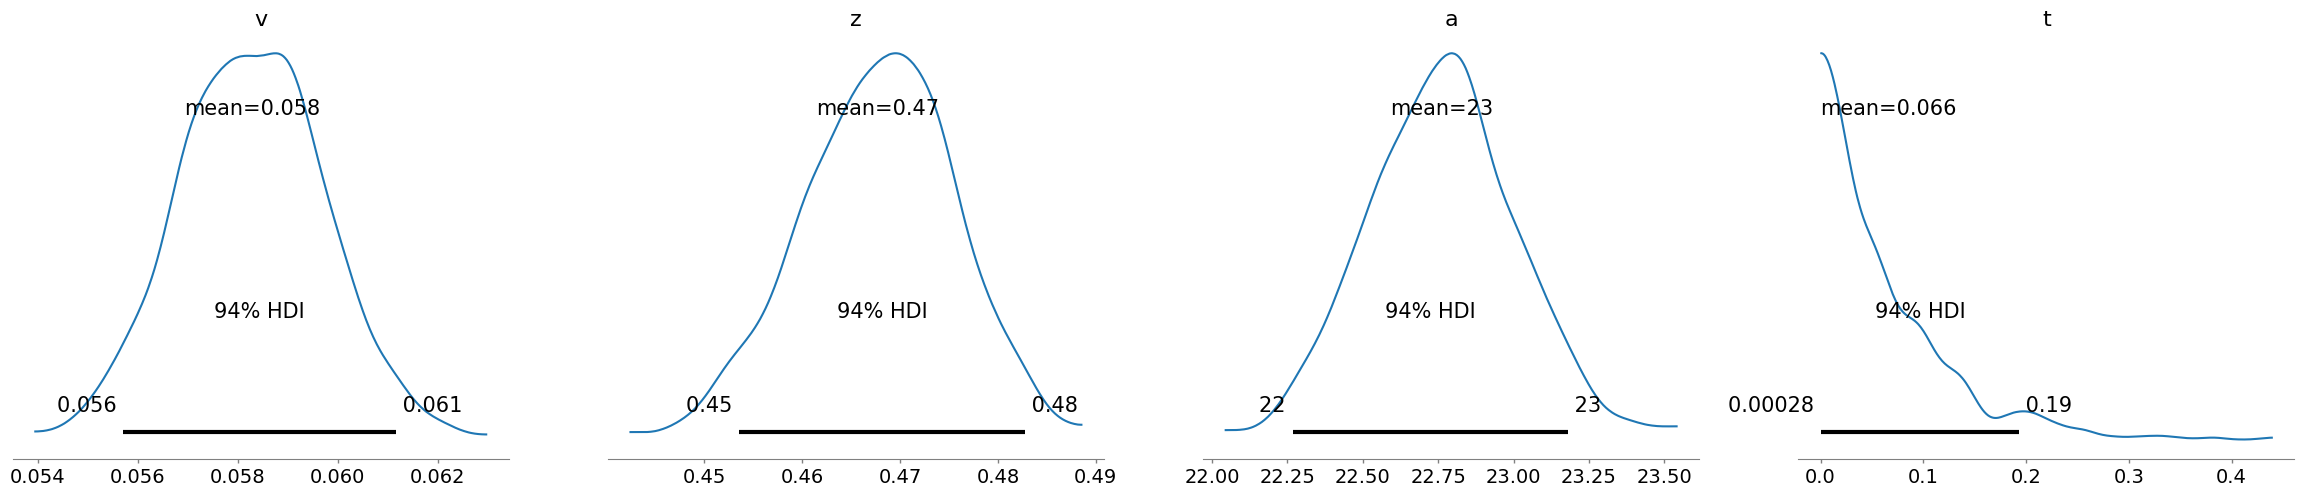

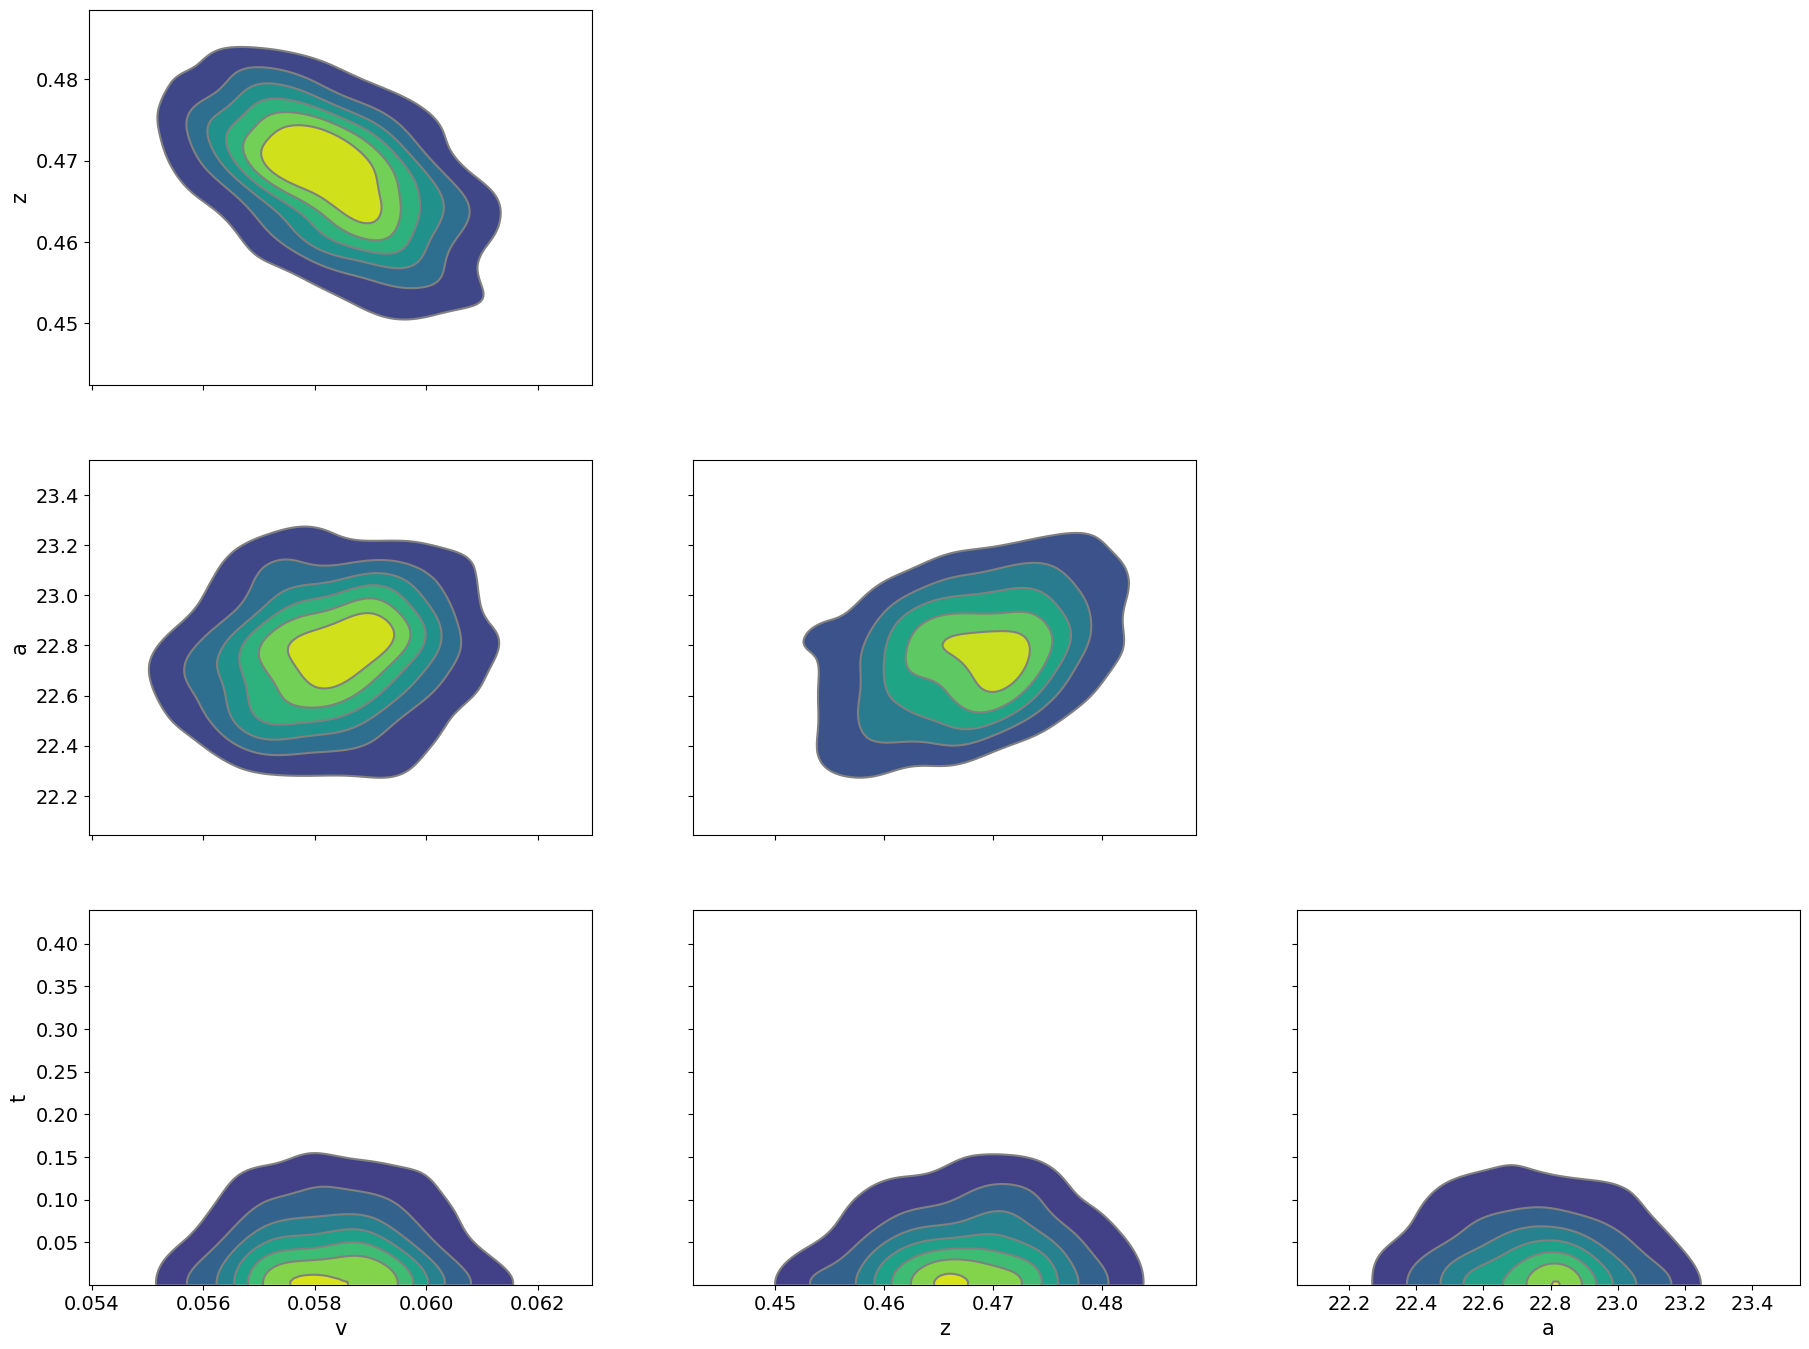

In [24]:
#japanese viz
az.plot_trace(
    infer_data_simple_ddm_model_japanese,
    var_names="~log_likelihood",  # we exclude the log_likelihood traces here
)
plt.tight_layout()

constant_values = np.all(df_japanese == df_japanese.iloc[0], axis=0)
print(constant_values)
# Check for NaN values
nan_values = df_japanese.isnull().any()
print(nan_values)

az.plot_forest(simple_ddm_model_japanese.traces)
az.plot_posterior(simple_ddm_model_japanese.traces)
az.plot_pair(simple_ddm_model_japanese.traces, kind="kde")
simple_ddm_model_japanese.loglik_kind

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['log_likelihood'] have not been found and will be ignored
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite val

rt          False
response    False
dtype: bool
rt          False
response    False
dtype: bool


'analytical'

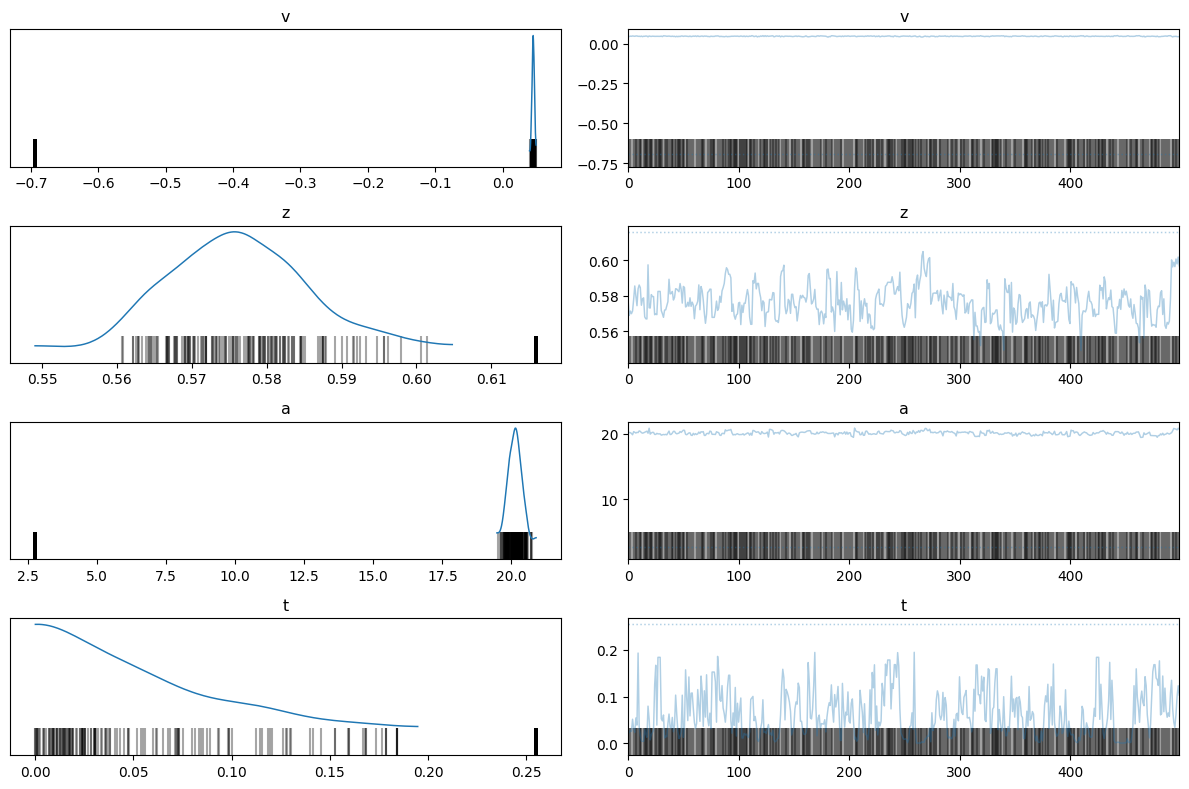

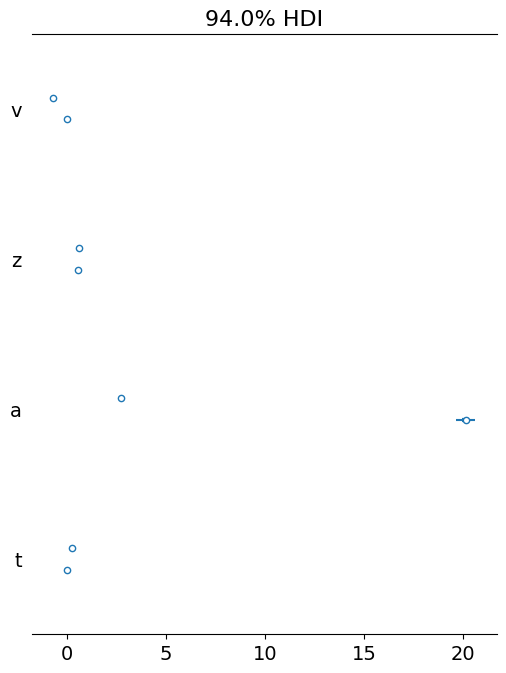

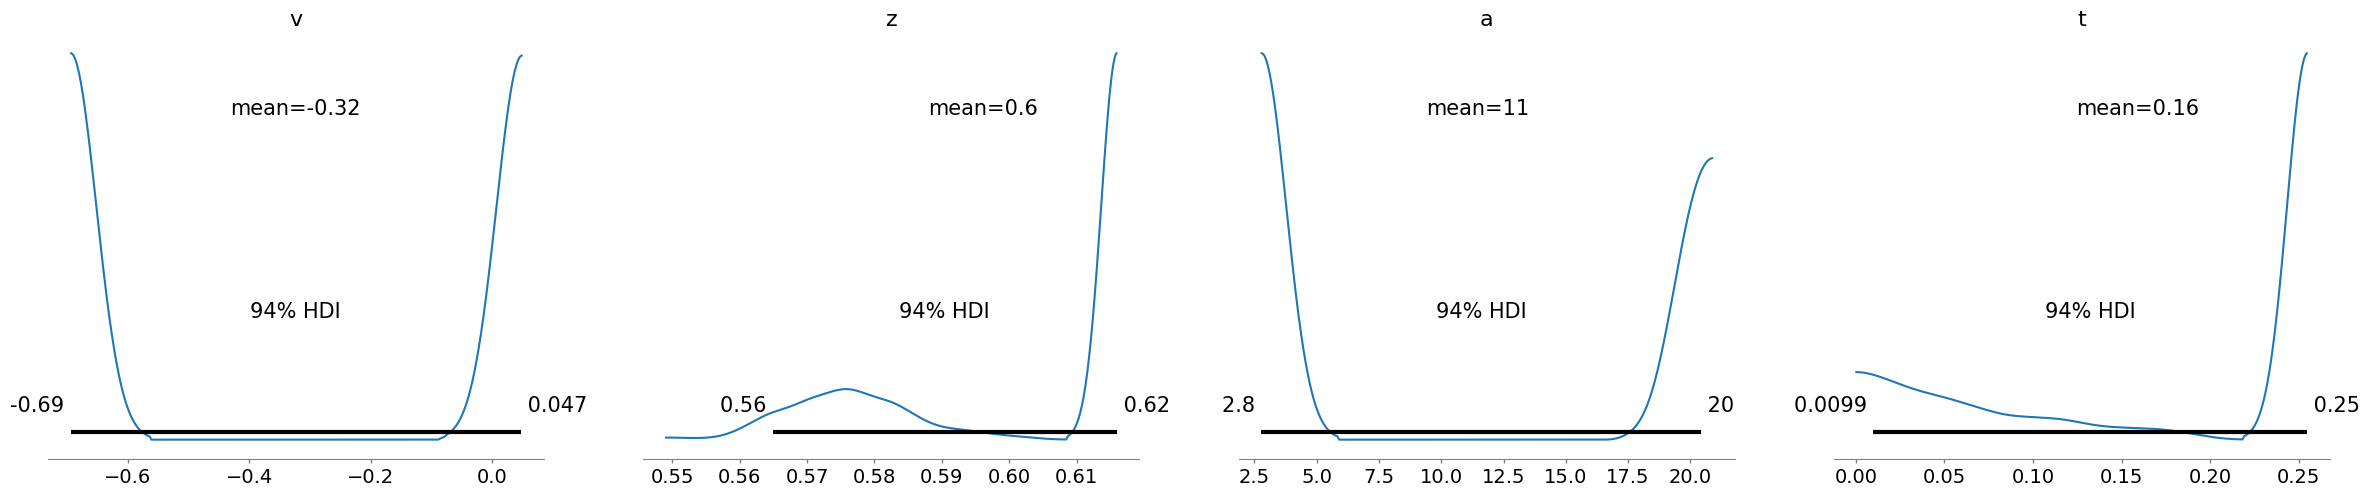

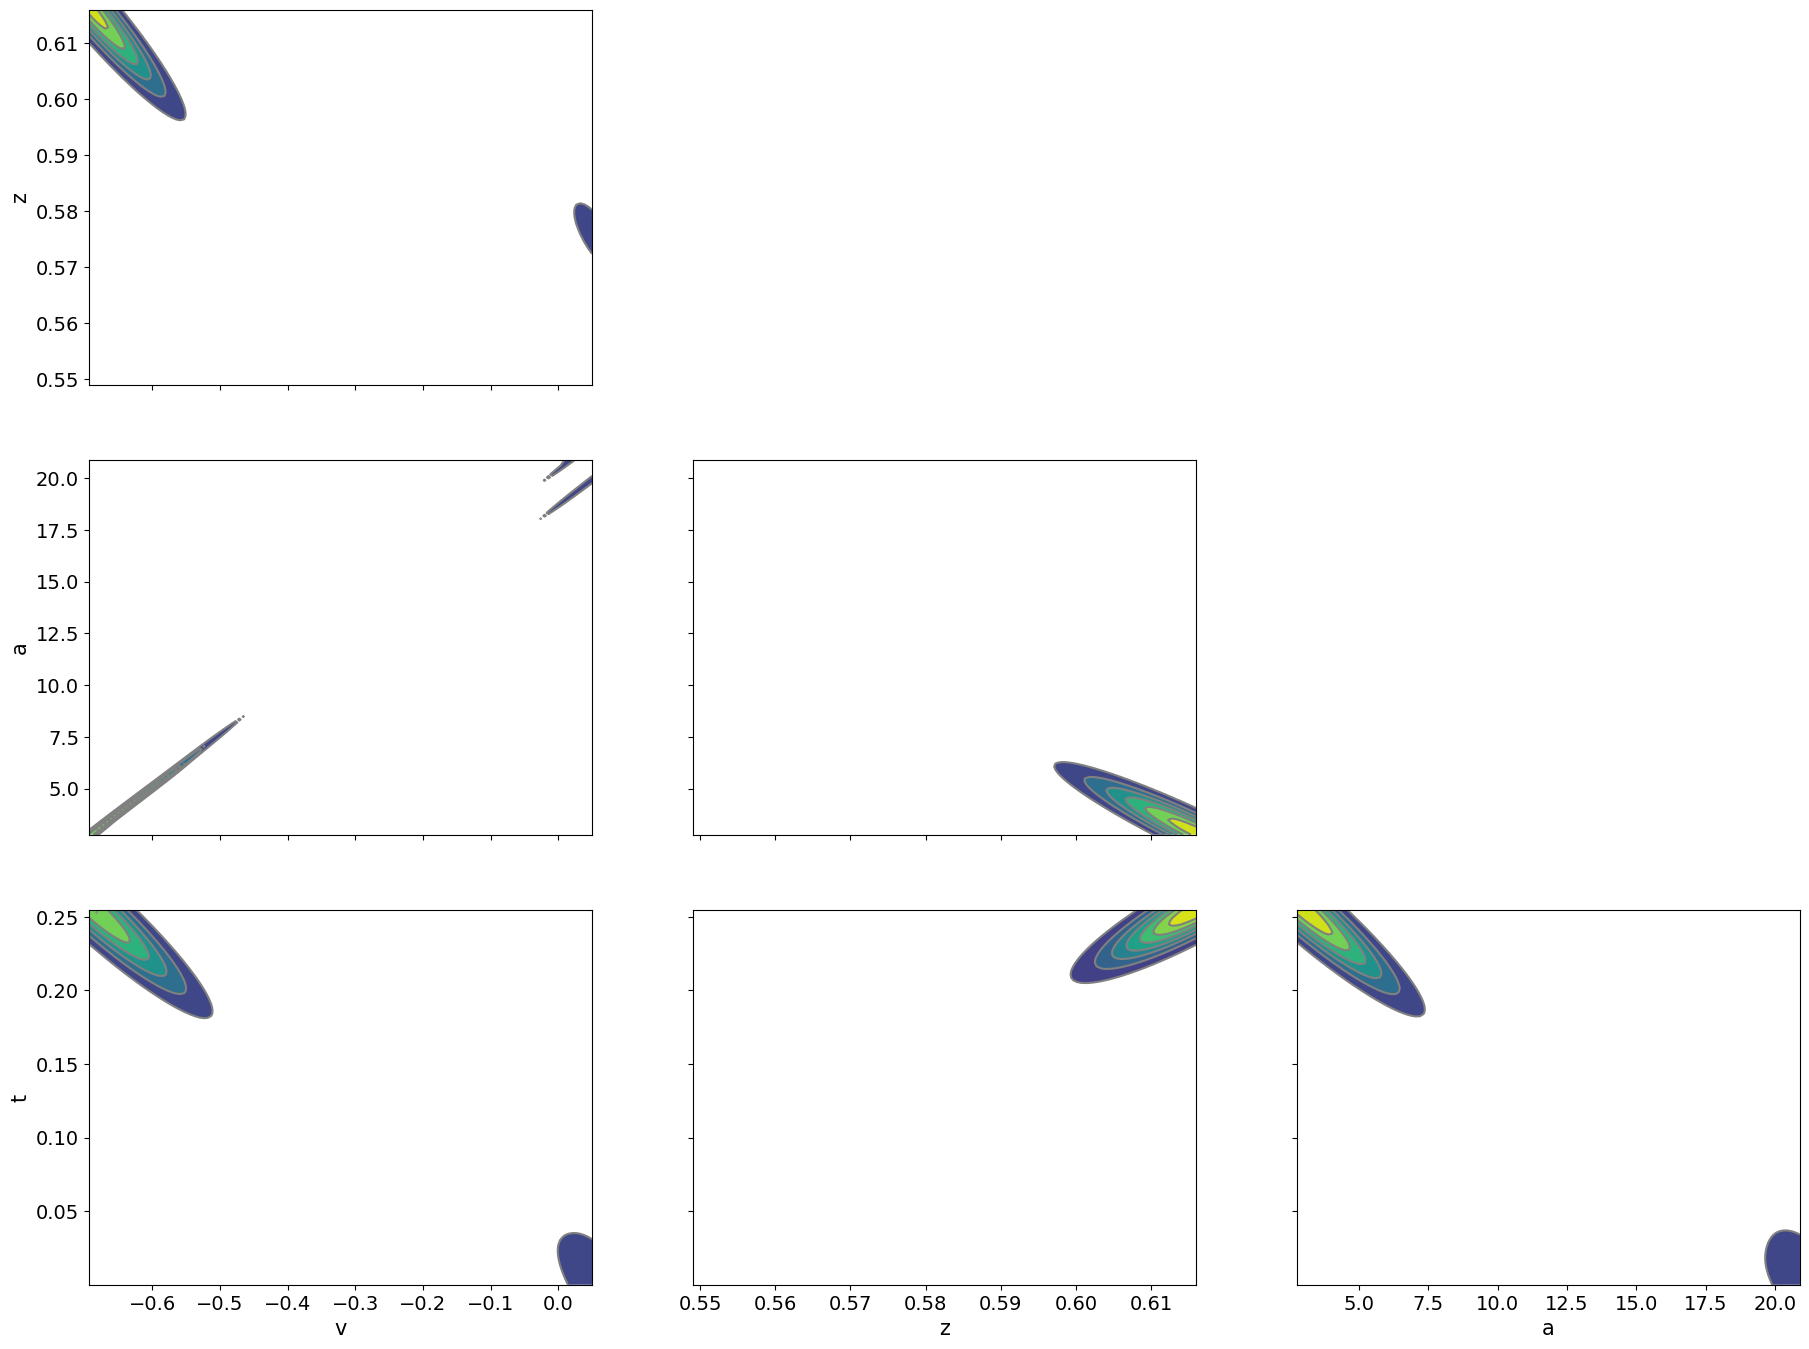

In [25]:
#italian viz
az.plot_trace(
    infer_data_simple_ddm_model_italian,
    var_names="~log_likelihood",  # we exclude the log_likelihood traces here
)
plt.tight_layout()

constant_values = np.all(df_italian == df_italian.iloc[0], axis=0)
print(constant_values)
# Check for NaN values
nan_values = df_italian.isnull().any()
print(nan_values)

az.plot_forest(simple_ddm_model_italian.traces)
az.plot_posterior(simple_ddm_model_italian.traces)
az.plot_pair(simple_ddm_model_italian.traces, kind="kde")
simple_ddm_model_italian.loglik_kind

      rt  response         x         y  subject
0  318.0         1  0.649675  0.655506  9353724
1  369.0         1  0.649675  0.655506  9353724
2  339.0         1  0.649675  0.655506  9353724
3  609.0         1  0.649675  0.655506  9353724
4  450.0         1  0.649675  0.655506  9353724
         rt  response         x         y  subject
3433  506.0         1  0.658009  0.626934  9342558
3434  865.0         1  0.658009  0.626934  9342558
3435  213.0         1  0.658009  0.626934  9342558
3436  215.0         1  0.658009  0.626934  9342558
3437  291.0         1  0.658009  0.626934  9342558
         rt  response         x         y  subject
5196  835.0         1  0.649675  0.655506  9353724
5197  369.0         1  0.649675  0.655506  9353724
5198  297.0         1  0.649675  0.655506  9353724
5199  265.0         1  0.649675  0.655506  9353724
5200  341.0         1  0.649675  0.655506  9353724


hierarchical *models*

In [42]:
#creating hierarchical dataframes
df['rt'] = df['Reaction.Time']
df['response'] = df['Answer_correct']
df['x'] = df['centered_beats']
df['y'] = df['centered_melody']
df['subject'] = df['Participant.Private.ID']
df['response'] = df['response'].replace({0: -1})


#create Mandarin df hierarchical
dfh_mandarin = df[df['Spreadsheet.Name'] == 'Mandarin']
dfh_mandarin = dfh_mandarin[['rt', 'response','x','y','subject']]

#create Mandarin df hierarchical
dfh_italian = df[df['Spreadsheet.Name'] == 'italian']
dfh_italian = dfh_italian[['rt', 'response','x','y','subject']]

#create Mandarin df hierarchical
dfh_japanese = df[df['Spreadsheet.Name'] == 'japanese']
dfh_japanese = dfh_japanese[['rt', 'response','x','y','subject']]

print(dfh_mandarin.head())
print(dfh_italian.head())
print(dfh_japanese.head())

      rt  response         x         y  subject
0  318.0         1  0.649675  0.655506  9353724
1  369.0         1  0.649675  0.655506  9353724
2  339.0         1  0.649675  0.655506  9353724
3  609.0         1  0.649675  0.655506  9353724
4  450.0         1  0.649675  0.655506  9353724
         rt  response         x         y  subject
3433  506.0         1  0.658009  0.626934  9342558
3434  865.0         1  0.658009  0.626934  9342558
3435  213.0         1  0.658009  0.626934  9342558
3436  215.0         1  0.658009  0.626934  9342558
3437  291.0         1  0.658009  0.626934  9342558
         rt  response         x         y  subject
5196  835.0         1  0.649675  0.655506  9353724
5197  369.0         1  0.649675  0.655506  9353724
5198  297.0         1  0.649675  0.655506  9353724
5199  265.0         1  0.649675  0.655506  9353724
5200  341.0         1  0.649675  0.655506  9353724


In [43]:
#example of hierarchical
#model_reg_v_angle_hier = hssm.HSSM(
#    data=dfh_mandarin,
#    model="angle",
#    include=[
#        {
#            "name": "v",
#            "prior": {
#                "Intercept": {
#                    "name": "Uniform",
#                    "lower": -3.0,
#                    "upper": 3.0,
#                    "initval": 0.0,
#                },
#                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
#                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
#            },
#            "formula": "v ~ 1 + (1|subject) + x + y",
#            "link": "identity",
#        }
#    ],
#)

In [47]:
model_reg_v_angle_hier = hssm.HSSM(
    data=dfh_mandarin,
    model="angle",
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject) + y",
            "link": "identity",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject) + x",
            "link": "identity",
        }
    ],
)

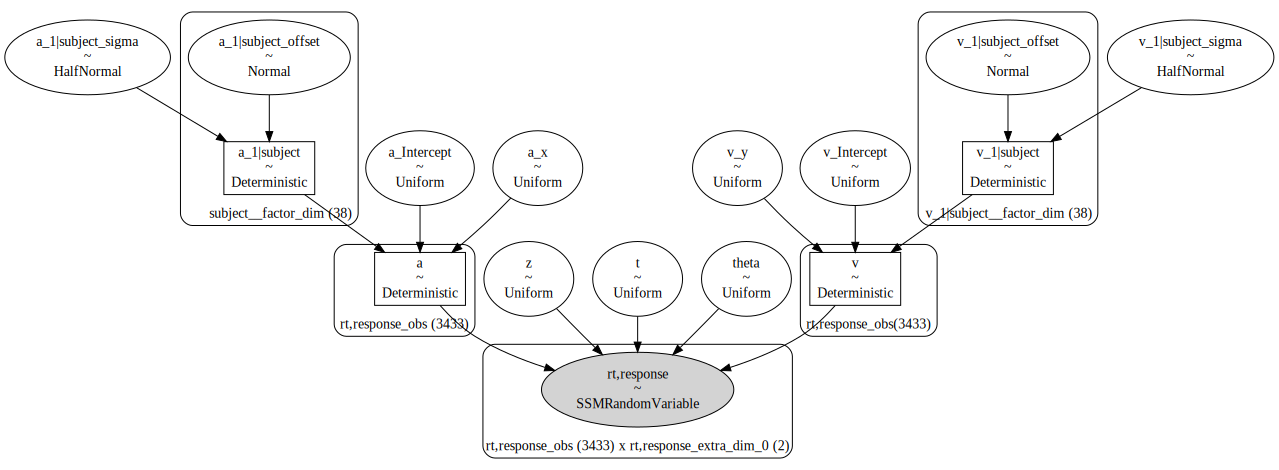

In [48]:
model_reg_v_angle_hier.graph()

In [49]:
from jax.config import config

config.update("jax_enable_x64", False)
model_reg_v_angle_hier.sample(
    sampler="nuts_numpyro", chains=2, cores=1, draws=1000, tune=1000
)

<ipython-input-49-41b693afd9f1>:1: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config
/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [53]:
print(model_reg_v_angle_hier.traces)

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data


In [54]:
# Set a reasonable figure size
plt.figure(figsize=(8, 4))
#plot output
az.plot_forest(model_reg_v_angle_hier.traces)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Error in callback <function _draw_all_if_interactive at 0x7b608dbf5fc0> (for post_execute):


ValueError: ignored

<Figure size 800x400 with 0 Axes>

ValueError: ignored

<Figure size 600x71860 with 1 Axes>